In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, AutoencoderKL
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [2]:
from pathlib import Path

In [3]:
'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'

'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'

In [4]:
path_data = Path('test_data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [5]:
from PIL import Image
import numpy as np
bs = 64
def to_img(f): 
    return np.array(Image.open(f))/255

In [6]:
from glob import glob
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): 
        return len(self.files)
    def __getitem__(self, i): 
        return torch.from_numpy(to_img(self.files[i]).transpose(2, 0, 1)[:, :256,:256]).float(), 0

In [7]:
dataset = ImagesDS(path / f'**/*.jpg')

In [8]:
len(dataset)

303125

In [9]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=False, num_workers=32)

In [10]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

In [11]:
b, _ = next(iter(train_dataloader))

In [12]:
lat = vae.encode(b.cuda()).latent_dist.sample()

In [13]:
lat.shape

torch.Size([8, 4, 32, 32])

In [14]:
dec = vae.decode(lat)

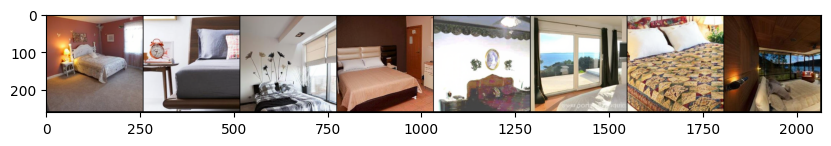

In [15]:
dec = torchvision.utils.make_grid(dec.sample.cpu()).numpy()
dec = np.clip(dec, 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(dec.transpose(1, 2, 0))
plt.show()

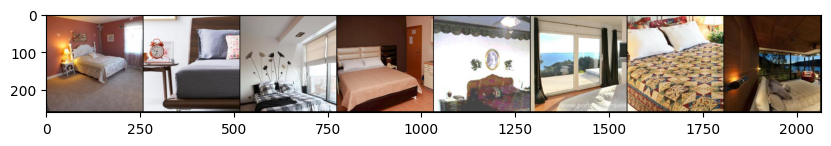

In [16]:
b = torchvision.utils.make_grid(b.cpu()).numpy()
b = np.clip(b, 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(b.transpose(1, 2, 0))
plt.show()

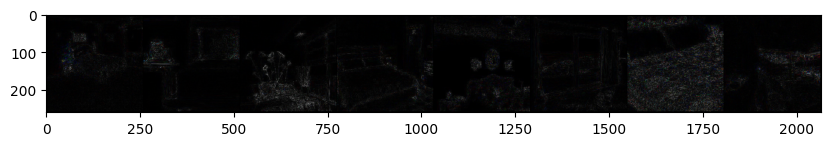

In [17]:
diff = np.abs(dec - b)
plt.figure(figsize=(10, 10))
plt.imshow(diff.transpose(1, 2, 0))
plt.show()

In [18]:
mmpath = Path('test_data/bedroom/data.npmm')

In [19]:
len(dataset)

303125

In [20]:
mmshape = (303125,4,32,32)


In [21]:
from tqdm.notebook import tqdm

In [22]:
if not mmpath.exists() and False:
    a = np.memmap(mmpath, np.float32, mode='w+', shape=mmshape)
    i = 0
    with torch.no_grad():
        for b, _ in tqdm(train_dataloader):
            n = len(b)
            a[i:i+n] = vae.encode(b.cuda()).latent_dist.mean.cpu().numpy()
            i += n
    a.flush()
    del(a)

In [23]:
from paintmind.stage1.diffusion_transfomers import DiT_S_8

In [24]:
from paintmind.stage1.diffusion import create_diffusion

In [25]:
create_diffusion

<function paintmind.stage1.diffusion.create_diffusion(timestep_respacing, noise_schedule='linear', use_kl=False, sigma_small=False, predict_xstart=False, learn_sigma=True, rescale_learned_sigmas=False, diffusion_steps=1000)>

In [26]:
model = DiT_S_8()

In [27]:
diffusion = create_diffusion(timestep_respacing="")

In [28]:
from tqdm.notebook import tqdm

In [29]:
# Redefining the dataloader to set the batch size higher than the demo of 8
train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=32)

# How many runs through the data should we do?
n_epochs = 3

# Our network 
net = model.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.AdamW(net.parameters(), lr=1e-4, weight_decay=0) 

# Keeping a record of the losses for later viewing
losses = []


In [30]:
print_every = 100

  0%|          | 0/2369 [00:00<?, ?it/s]

Step 100. Loss: 0.25548917055130005
Step 200. Loss: 0.20525649189949036
Step 300. Loss: 0.21404889225959778
Step 400. Loss: 0.1481141597032547
Step 500. Loss: 0.17469623684883118
Step 600. Loss: 0.18115080893039703
Step 700. Loss: 0.23179113864898682
Step 800. Loss: 0.14485034346580505
Step 900. Loss: 0.20463669300079346
Step 1000. Loss: 0.22001130878925323
Step 1100. Loss: 0.15406078100204468
Step 1200. Loss: 0.14405924081802368
Step 1300. Loss: 0.20514217019081116
Step 1400. Loss: 0.1524006724357605
Step 1500. Loss: 0.20222121477127075
Step 1600. Loss: 0.1791677325963974
Step 1700. Loss: 0.18140605092048645
Step 1800. Loss: 0.1746654361486435
Step 1900. Loss: 0.2185571789741516
Step 2000. Loss: 0.1293947696685791
Step 2100. Loss: 0.1697230339050293
Step 2200. Loss: 0.1413416862487793
Step 2300. Loss: 0.16753411293029785
Finished epoch 0. Average of the last 100 loss values: 0.176081


  0%|          | 0/2369 [00:00<?, ?it/s]

Step 2400. Loss: 0.20132288336753845
Step 2500. Loss: 0.18047547340393066
Step 2600. Loss: 0.1516338288784027
Step 2700. Loss: 0.2146952748298645
Step 2800. Loss: 0.13367708027362823
Step 2900. Loss: 0.16718457639217377
Step 3000. Loss: 0.13548655807971954
Step 3100. Loss: 0.1742049753665924
Step 3200. Loss: 0.18830019235610962
Step 3300. Loss: 0.15837478637695312
Step 3400. Loss: 0.22991082072257996
Step 3500. Loss: 0.2264830470085144
Step 3600. Loss: 0.24141016602516174
Step 3700. Loss: 0.1741851568222046
Step 3800. Loss: 0.17365533113479614
Step 3900. Loss: 0.1816539764404297
Step 4000. Loss: 0.20628289878368378
Step 4100. Loss: 0.20670656859874725
Step 4200. Loss: 0.14403805136680603
Step 4300. Loss: 0.19188284873962402
Step 4400. Loss: 0.13274742662906647
Step 4500. Loss: 0.21707762777805328
Step 4600. Loss: 0.17947189509868622
Step 4700. Loss: 0.21303485333919525
Finished epoch 1. Average of the last 100 loss values: 0.169961


  0%|          | 0/2369 [00:00<?, ?it/s]

Step 4800. Loss: 0.1867114007472992
Step 4900. Loss: 0.17775331437587738
Step 5000. Loss: 0.1123618334531784
Step 5100. Loss: 0.19698360562324524
Step 5200. Loss: 0.17172305285930634
Step 5300. Loss: 0.19961196184158325
Step 5400. Loss: 0.15606212615966797
Step 5500. Loss: 0.19146868586540222
Step 5600. Loss: 0.1629861295223236
Step 5700. Loss: 0.1763973832130432
Step 5800. Loss: 0.21325212717056274
Step 5900. Loss: 0.16977864503860474
Step 6000. Loss: 0.15444415807724
Step 6100. Loss: 0.16488245129585266
Step 6200. Loss: 0.24740783870220184
Step 6300. Loss: 0.14266180992126465
Step 6400. Loss: 0.14378467202186584
Step 6500. Loss: 0.20022909343242645
Step 6600. Loss: 0.16246774792671204
Step 6700. Loss: 0.2111392617225647
Step 6800. Loss: 0.1675405502319336
Step 6900. Loss: 0.1654263585805893
Step 7000. Loss: 0.16990742087364197
Step 7100. Loss: 0.18378743529319763
Finished epoch 2. Average of the last 100 loss values: 0.173680


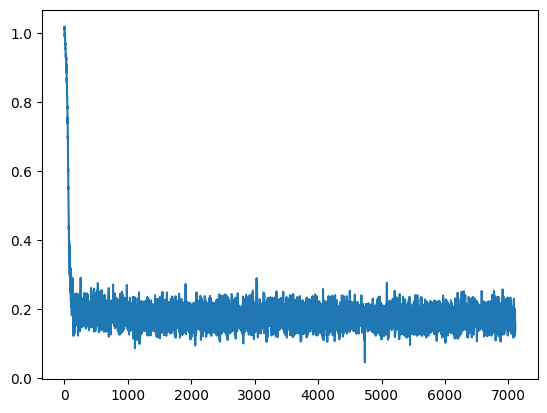

In [31]:

# The training loop
step = 0
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        step += 1

        x = x.to(device) # Data on the GPU (mapped to (-1, 1))
        with torch.no_grad():
            # Map input images to latent space + normalize latents:
            x = vae.encode(x).latent_dist.sample().mul_(0.18215)
        y = y.to(device)

        t = torch.randint(0, diffusion.num_timesteps, (x.shape[0],), device=device)
        model_kwargs = dict(y=y)
        loss_dict = diffusion.training_losses(model, x, t, model_kwargs)
        loss = loss_dict["loss"].mean()

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())
        if step % print_every == 0:
            print(f'Step {step}. Loss: {loss.item()}')


    # Print out the average of the last 100 loss values to get an idea of progress:
    avg_loss = sum(losses[-100:])/100
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.show()

In [32]:
z = torch.randn(4, 4, 32, 32, device=device)
y = torch.tensor([0, 0, 0, 0], device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * 4, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=0.0)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

  0%|          | 0/1000 [00:00<?, ?it/s]

In [33]:
torch.save(samples, 'samples_dit_lsun.pth')

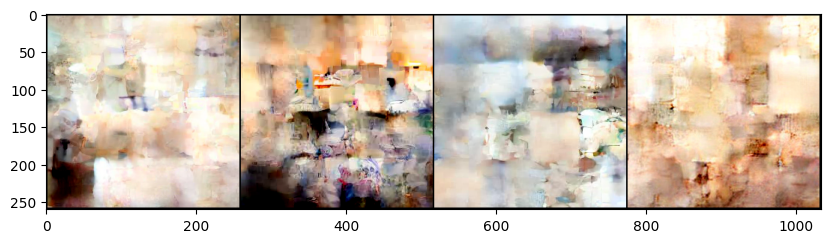

In [35]:
samples = torchvision.utils.make_grid(samples.cpu()).numpy()
samples = np.clip(samples, 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(samples.transpose(1, 2, 0))
plt.show()